In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../Data/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [4]:
df.columns = ['Products']

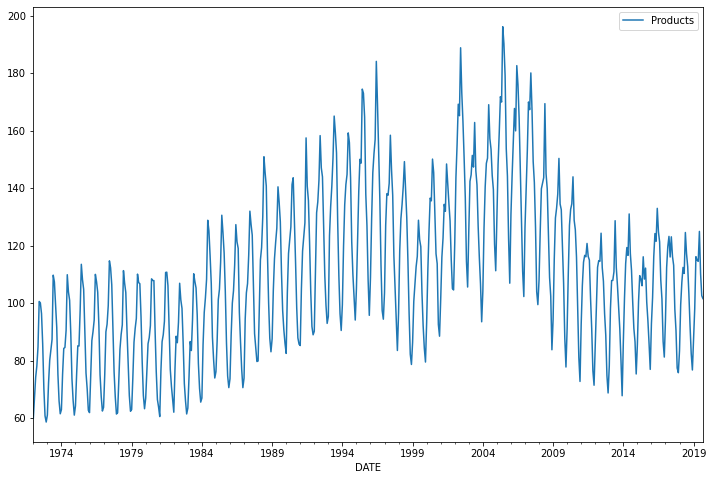

In [5]:
df.plot(figsize=(12,8))

In [6]:
len(df)

573

In [7]:
test_size = 24
test_data = len(df) - test_size
train = df.iloc[:test_data]
test = df.iloc[test_data:]

24

In [8]:
len(test)

24

In [9]:
len(train)

549

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [12]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
length=18
Generator = TimeseriesGenerator(scaled_train,scaled_train,length=length, batch_size=1)

In [25]:
n_features = 1
model = Sequential()

model.add(LSTM(100,activation = 'relu',input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [27]:
Validation_Generator = TimeseriesGenerator(scaled_test,scaled_test,length=length, batch_size=1)
early_stop = EarlyStopping(monitor='val_loss',patience=2)
model.fit_generator(Generator,validation_data=Validation_Generator,epochs=15,callbacks=early_stop)

Epoch 1/15
531/531 [==============================] - 4s 7ms/step - loss: 0.0258 - val_loss: 0.0046
Epoch 2/15
531/531 [==============================] - 4s 7ms/step - loss: 0.0131 - val_loss: 0.0029
Epoch 3/15
531/531 [==============================] - 4s 7ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 4/15
531/531 [==============================] - 3s 6ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 5/15
531/531 [==============================] - 4s 7ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 6/15
531/531 [==============================] - 3s 6ms/step - loss: 0.0031 - val_loss: 0.0032


In [28]:
loss = pd.DataFrame(model.history.history)

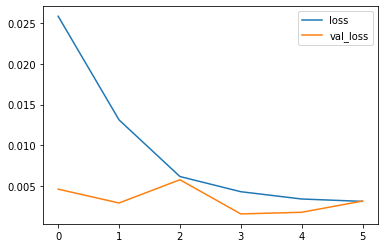

In [29]:
loss.plot()

In [30]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Prediction'] = true_predictions

<ipython-input-31-b4730d6b22e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = true_predictions


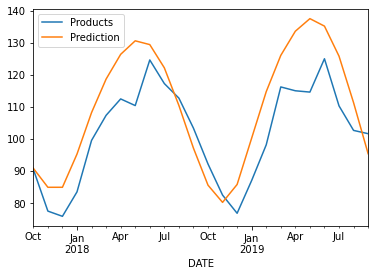

In [32]:
test.plot()